# Импрортируем библиотеки

In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import scipy.signal as sig
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import metrics
from math import sqrt
import math

In [6]:
# Метрики качества прогноза
def MAPE(y_pred, y_true):
    n = len(y_pred)
    return 1 / n * sum(abs((y_true - y_pred) / y_true))

def RMSE(y_pred, y_true):
    n = len(y_pred)
    return  np.sqrt(1 / n * sum((y_pred - y_true) ** 2))

# Подгрузим данные

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100, style = 'bmh'):
    with plt.style.context(style):
        plt.figure(figsize=(16,5), dpi=dpi)
        plt.plot(x, y, color='tab:blue')
        plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
        plt.show()

plot_df(df, x=df.index, y=df.value, title='Monthly anti-diabetic drug sales in Australia from 1992 to 2008.')

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

### Предобработка данных

#### Переменные тренда

In [5]:
trend_features = pd.DataFrame(index=df.index)
trend_features['t'] = [x for x in range(1,len(df)+1)]
trend_features['t2'] = [x**2 for x in range(1,len(df)+1)]

#### Переменные сезонности

In [45]:
df['month'] = [x.month_name() for x in df.reset_index()['date']]
seasonal_features = pd.get_dummies(df['month'],drop_first = True)

#### Итоговый датасет

In [60]:
np.log(3)

1.0986122886681098

In [53]:
seasonal_features

,August,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,
1991-07-01,0,0,0,0,1,0,0,0,0,0,0
1991-08-01,1,0,0,0,0,0,0,0,0,0,0
1991-09-01,0,0,0,0,0,0,0,0,0,0,1
1991-10-01,0,0,0,0,0,0,0,0,0,1,0
1991-11-01,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2008-02-01,0,0,1,0,0,0,0,0,0,0,0
2008-03-01,0,0,0,0,0,0,1,0,0,0,0
2008-04-01,0,0,0,0,0,0,0,0,0,0,0


In [7]:
X=pd.concat([trend_features,seasonal_features],axis=1)
y=df['value']

y_log=np.log(y) # для реализации модели log-lin

data = pd.concat([X,y],axis=1) # DataFrame для кросс-валидации 

#### Выделение обучающей и тестовой выборки

In [64]:
df

,value,month
date,,
1991-07-01,3.526591,July
1991-08-01,3.180891,August
1991-09-01,3.252221,September
1991-10-01,3.611003,October
1991-11-01,3.565869,November
...,...,...
2008-02-01,21.654285,February
2008-03-01,18.264945,March
2008-04-01,23.107677,April


In [8]:
horizon = 12
# Обучающая выборка
X_train = X.head(-horizon) # или X[:-horizon]
y_train = y.head(-horizon) 

y_train_log = y_log.head(-horizon)
y_test_log = y_log.tail(horizon)

# Выборка на валидацию (проверка качества) модели (тестовая выборка)
X_test = X.tail(horizon) # или X[-horizon:]
y_test = y.tail(horizon)

### Построение моделей

#### Списки названий факторов

In [9]:
features_list1 = ['t']
features_list2 = ['t','t2']
features_list3 = features_list1 + seasonal_features.columns.to_list()
features_list4 = features_list2 + seasonal_features.columns.to_list()

#### Модели в абсолютных значениях

In [79]:
model_1 = LinearRegression().fit(X_train[features_list1],y_train) # линейный тренд
model_2 = LinearRegression().fit(X_train[features_list2],y_train) # квадратичный тренд
model_3 = LinearRegression().fit(X_train[features_list3],y_train) # линейный тренд + сез.фиктив. переменные
model_4 = LinearRegression().fit(X_train[features_list4],y_train) # квадратичный тренд + сез.фиктив. переменные

predict_1 = model_1.predict(X_test[features_list1])
predict_2 = model_2.predict(X_test[features_list2])
predict_3 = model_3.predict(X_test[features_list3])
predict_4 = model_4.predict(X_test[features_list4])

In [81]:
features_list3

['t',
 'August',
 'December',
 'February',
 'January',
 'July',
 'June',
 'March',
 'May',
 'November',
 'October',
 'September']

In [80]:
print(f'MAPE: {round(MAPE(y_pred = predict_1, y_true = y_test)*100,3)}%')
print(f'MAPE: {round(MAPE(y_pred = predict_2, y_true = y_test)*100,3)}%')
print(f'MAPE: {round(MAPE(y_pred = predict_3, y_true = y_test)*100,3)}%')
print(f'MAPE: {round(MAPE(y_pred = predict_4, y_true = y_test)*100,3)}%')

MAPE: 18.658%
MAPE: 12.387%
MAPE: 18.439%
MAPE: 11.107%


**Функция кросс-валидации**

In [11]:
def rolling_cv(model_obj, X, y, folds, horizon, logs=False,shift=True):
    mape_mean=0
    for i in range(folds):
        if shift==True:
            train_ind_start,train_ind_end=0,len(X)-(i+1)*horizon
        else:
            train_ind_start,train_ind_end=0,len(X)-(i+horizon)
            
        test_ind_start,test_ind_end=train_ind_end,train_ind_end+horizon
        
        X_train,y_train=X[train_ind_start:train_ind_end],y[train_ind_start:train_ind_end]
        X_test,y_test=X[test_ind_start:test_ind_end],y[test_ind_start:test_ind_end]
        
        print(f'Train: [{train_ind_start}:{train_ind_end}),Test: [{test_ind_start}:{test_ind_end})')
        
        model=model_obj.fit(X_train,y_train)
        if logs==False:
            mape_i=MAPE(y_true=y_test,y_pred=model.predict(X_test))
        else:
            mape_i=MAPE(y_true=np.exp(y_test),y_pred=np.exp(model.predict(X_test)))
            
        print(f'MAPE on Fold {i+1}: {round(mape_i,4)}')
        
        mape_mean += mape_i
    return round(mape_mean/folds,4)

In [12]:
rolling_cv(LinearRegression(),X_train,y_train,6,12,shift=False)

Train: [0:180),Test: [180:192)
MAPE on Fold 1: 0.1017
Train: [0:179),Test: [179:191)
MAPE on Fold 2: 0.0981
Train: [0:178),Test: [178:190)
MAPE on Fold 3: 0.0923
Train: [0:177),Test: [177:189)
MAPE on Fold 4: 0.0976
Train: [0:176),Test: [176:188)
MAPE on Fold 5: 0.0957
Train: [0:175),Test: [175:187)
MAPE on Fold 6: 0.1159


0.1002

In [13]:
Xtr = pd.concat([X_train, y_train],axis = 1)

In [14]:
calc_metric(features, Xtr,target='value',folds = 4, h = 12)

NameError: name 'calc_metric' is not defined

In [15]:
# Чтобы функция работала верно, необходимо чтобы models_name[i] соответствовал features[i]

models_name = ['Linear', 'Quadratic', 'Linear with Dummy', 'Quadratic with Dummy']
features = [features_list1, features_list2, features_list3, features_list4] 

def calc_metric(features, data,target,folds, h):
    TestModels = pd.DataFrame()
    tmp = {} 
    
    for feature in features:
        if feature == features[0]:
            cv1 = []
            cv2 = []
            m = models_name[0]
            tmp['Model'] = m
        
            for i in range(1,folds + 1):


                l = len(data) - i*h # h = 12, i = 1, то l = 192
                
                train_data = data[0:l]
                test_data = data[l:l+h]

                model_i = LinearRegression().fit(train_data[feature],train_data[target])
                pred_i = model_i.predict(test_data[feature])

                cv1.append(round(RMSE(pred_i,np.array(test_data[target])),4))
                cv2.append(round(MAPE(pred_i,np.array(test_data[target])),4))
        
            tmp['RMSE'] = np.mean(cv1)
            tmp['MAPE'] = np.mean(cv2)
            
        if feature == features[1]:
            cv1 = []
            cv2 = []
            m = models_name[1]
            tmp['Model'] = m
        
            for i in list(range(1,folds + 1)):


                l = len(data) - i*h
                
                train_data = data[0:l]
                test_data = data[l:l+h]

                model_i = LinearRegression().fit(train_data[feature],train_data[target])
                pred_i = model_i.predict(test_data[feature])

                cv1.append(round(RMSE(pred_i,np.array(test_data[target])),4))
                cv2.append(round(MAPE(pred_i,np.array(test_data[target])),4))
        
            tmp['RMSE'] = np.mean(cv1)
            tmp['MAPE'] = np.mean(cv2)
            

        if feature == features[2]:
            cv1 = []
            cv2 = []
            m = models_name[2]
            tmp['Model'] = m
        
            for i in list(range(1,folds + 1)):


                l = len(data) - i*h
                
                train_data = data[0:l]
                test_data = data[l:l+h]

                model_i = LinearRegression().fit(train_data[feature],train_data[target])
                pred_i = model_i.predict(test_data[feature])

                cv1.append(round(RMSE(pred_i,np.array(test_data[target])),4))
                cv2.append(round(MAPE(pred_i,np.array(test_data[target])),4))
                
            tmp['RMSE'] = np.mean(cv1)
            tmp['MAPE'] = np.mean(cv2)

        if feature == features[3]:
            cv1 = []
            cv2 = []
            m = models_name[3]
            tmp['Model'] = m
        
            for i in list(range(1,folds + 1)):


                l = len(data) - i*h
                
                train_data = data[0:l]
                test_data = data[l:l+h]
                
                print(f'Train: [{0}:{l}),Test: [{l}:{l+h})')

                model_i = LinearRegression().fit(train_data[feature],train_data[target])
                pred_i = model_i.predict(test_data[feature])

                cv1.append(round(RMSE(pred_i,np.array(test_data[target])),4))
                cv2.append(round(MAPE(pred_i,np.array(test_data[target])),4))
                
            tmp['RMSE'] = np.mean(cv1)
            tmp['MAPE'] = np.mean(cv2)
            
        TestModels = TestModels.append([tmp])
    TestModels.set_index('Model',inplace = True)
    
    return TestModels
    
#     horizon = [1,3,6,9,12] 

In [16]:
Xtr = pd.concat([X,y],axis = 1)
calc_metric(features, Xtr,target = 'value',folds = 4, h = 12)

Train: [0:192),Test: [192:204)
Train: [0:180),Test: [180:192)
Train: [0:168),Test: [168:180)
Train: [0:156),Test: [156:168)


,RMSE,MAPE
Model,,
Linear,4.103625,0.155775
Quadratic,3.167425,0.126800
Linear with Dummy,3.369225,0.138850
Quadratic with Dummy,2.172250,0.092700


In [17]:
# Создаем временные структуры
TestModels_test = pd.DataFrame()
tmp = {} # В словаре будут храниться параметры после обучения
score = [] # В списке будут результаты

for model in models_name:
    if model == models_name[0]:
        m = models_name[0]
        tmp['Model'] = m
        
        tmp['RMSE'] = round(RMSE(predict_1,np.array(y_test)),4)
        tmp['MAPE'] = round(MAPE(predict_1,np.array(y_test)),4)
        tmp['Accuracy'] = round(1 - tmp['RMSE']/np.mean(y_test),4)

    if model == models_name[1]:
        m = models_name[1]
        tmp['Model'] = m
        
        tmp['RMSE'] = round(RMSE(predict_2,np.array(y_test)),4)
        tmp['MAPE'] = round(MAPE(predict_2,np.array(y_test)),4)
        tmp['Accuracy'] = round(1 - tmp['RMSE']/np.mean(y_test),4)
        
    if model == models_name[2]:
        m = models_name[2]
        
        tmp['Model'] = m
        
        tmp['RMSE'] = round(RMSE(predict_3,np.array(y_test)),4)
        tmp['MAPE'] = round(MAPE(predict_3,np.array(y_test)),4)
        tmp['Accuracy'] = round(1 - tmp['RMSE']/np.mean(y_test),4)

    if model == models_name[3]:
        m = models_name[3]
        
        tmp['Model'] = m
        
        tmp['RMSE'] = round(RMSE(predict_4,np.array(y_test)),4)
        tmp['MAPE'] = round(MAPE(predict_4,np.array(y_test)),4)
        tmp['Accuracy'] = round(1 - tmp['RMSE']/np.mean(y_test),4)
    # Записываем данные и итоговый результат DataFrame
    TestModels_test = TestModels_test.append([tmp])
    
# Делаем индекс по названию модели
TestModels_test.set_index('Model',inplace = True)
TestModels_test

,RMSE,MAPE,Accuracy
Model,,,
Linear,5.3502,0.1866,0.7691
Quadratic,3.6246,0.1239,0.8436
Linear with Dummy,4.8223,0.1844,0.7919
Quadratic with Dummy,2.7891,0.1111,0.8796


**Проверяем качество аппроксимации (оценки модели) на обучающей выборке**

In [1]:
# Расчетные значения целевой переменной (y_t)

Calc_value_1 = model_1.predict(X_train[features_list1]) 
Calc_value_2 = model_2.predict(X_train[features_list2])
Calc_value_3 = model_3.predict(X_train[features_list3])
Calc_value_4 = model_4.predict(X_train[features_list4])

NameError: name 'model_1' is not defined

In [19]:
TestModels_train = pd.DataFrame()
tmp = {} # В словаре будут храниться параметры после обучения
T = len(X_train) # T - длина обучающей выборки

models_name = ['Linear', 'Quadratic', 'Linear with Dummy', 'Quadratic with Dummy']

for model in models_name:
    if model == models_name[0]:
        n = 1 # n - количество факторов
        m = models_name[0]
        tmp['Model'] = m
        
        tmp['RSS'] = round(np.sum((np.array(y_train) - Calc_value_1)**2),2)
        tmp['TSS'] = round(np.sum((np.array(y_train) - np.mean(y_train))**2),2)
        tmp['ESS'] = round(np.sum((Calc_value_1 - np.mean(y_train))**2),2)
        
        tmp['AIC'] = round(np.log(tmp['RSS']/T) + 2*(n+1)/T,2)
        tmp['BIC'] = round(np.log(tmp['RSS']/T) + np.log(T)*(n+1)/T,2)
        
        tmp['R^2'] = round(tmp['ESS'] / tmp['TSS'],2)
#         tmp['R^2'] = r2_score(list(y_train), Calc_value_1)

    if model == models_name[1]:
        n = 2
        m = models_name[1]
        tmp['Model'] = m
        
        tmp['RSS'] = round(np.sum((np.array(y_train) - Calc_value_2)**2),2)
        tmp['TSS'] = round(np.sum((np.array(y_train) - np.mean(y_train))**2),2)
        tmp['ESS'] = round(np.sum((Calc_value_2 - np.mean(y_train))**2),2)
        tmp['AIC'] = round(np.log(tmp['RSS']/T) + 2*(n+1)/T,2)
        tmp['BIC'] = round(np.log(tmp['RSS']/T) + np.log(T)*(n+1)/T,2)
        
        tmp['R^2'] = round(tmp['ESS'] / tmp['TSS'],2)
        #tmp['R^2'] = r2_score(list(y_train), Calc_value_2)

    if model == models_name[2]:
        n = 12
        m = models_name[2]
        tmp['Model'] = m
        
        tmp['RSS'] = round(np.sum((np.array(y_train) - Calc_value_3)**2),2)
        tmp['TSS'] = round(np.sum((np.array(y_train) - np.mean(y_train))**2),2)
        tmp['ESS'] = round(np.sum((Calc_value_3 - np.mean(y_train))**2),2)
        tmp['AIC'] = round(np.log(tmp['RSS']/T) + 2*(n+1)/T,2)
        tmp['BIC'] = round(np.log(tmp['RSS']/T) + np.log(T)*(n+1)/T,2)
        
        tmp['R^2'] = round(tmp['ESS'] / tmp['TSS'],2)
        #tmp['R^2'] = r2_score(list(y_train), Calc_value_3)
        
    if model == models_name[3]:
        m = models_name[3]
        tmp['Model'] = m
        
        tmp['RSS'] = round(np.sum((np.array(y_train) - Calc_value_4)**2),2)
        tmp['TSS'] = round(np.sum((np.array(y_train) - np.mean(y_train))**2),2)
        tmp['ESS'] = round(np.sum((Calc_value_4 - np.mean(y_train))**2),2)
        tmp['AIC'] = round(np.log(tmp['RSS']/T) + 2*(n+1)/T,2)
        tmp['BIC'] = round(np.log(tmp['RSS']/T) + np.log(T)*(n+1)/T,2)
        
        tmp['R^2'] = round(tmp['ESS'] / tmp['TSS'],2)
        #tmp['R^2'] = r2_score(list(y_train), Calc_value_4)
        
    TestModels_train = TestModels_train.append([tmp])
    
TestModels_train.set_index('Model',inplace = True)
TestModels_train

NameError: name 'Calc_value_1' is not defined

#### Проверим статистическую значимость моделей 

In [20]:
df1 = pd.concat([X_train,y_train], axis =1)

In [21]:
import statsmodels.formula.api as smf
model_stats_1 = smf.ols('value ~ t', data=df1)
res1 = model_stats_1.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     1104.
Date:                Sat, 08 Oct 2022   Prob (F-statistic):           4.48e-81
Time:                        11:52:25   Log-Likelihood:                -403.54
No. Observations:                 192   AIC:                             811.1
Df Residuals:                     190   BIC:                             817.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6079      0.288      5.577      0.000       1.039       2.177
t              0.0861      0.003     33.223      0.000       0.081       0.091
==============================================================================
Omnibus:                       58.489   Durbin-Watson:                   1.167
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              172.940
Skew:                           1.250   Prob(JB):                     2.80e-38
Kurtosis:                       6.920   Cond. No.                         223.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
model_stats_2 = smf.ols('value ~ t + t^2', data=df1)
res2 = model_stats_2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     592.2
Date:                Sat, 08 Oct 2022   Prob (F-statistic):           4.03e-82
Time:                        11:52:26   Log-Likelihood:                -397.30
No. Observations:                 192   AIC:                             800.6
Df Residuals:                     189   BIC:                             810.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6079      0.280      5.746      0.000       1.056       2.160
t              0.3343      0.070      4.794      0.000       0.197       0.472
t ^ 2         -0.2482      0.070     -3.562      0.000      -0.386      -0.111
==============================================================================
Omnibus:                       54.243   Durbin-Watson:                   1.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.739
Skew:                           1.181   Prob(JB):                     3.05e-33
Kurtosis:                       6.624   Cond. No.                         316.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
model_stats_3 = smf.ols('value ~ t + January + February+March+May+June+July+August+September+October+November+December ', data=df1)
res3 = model_stats_3.fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     205.5
Date:                Sat, 08 Oct 2022   Prob (F-statistic):           8.24e-98
Time:                        11:52:26   Log-Likelihood:                -329.14
No. Observations:                 192   AIC:                             684.3
Df Residuals:                     179   BIC:                             726.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0494      0.392      0.126      0.900      -0.725       0.824
t              0.0866      0.002     47.684      0.000       0.083       0.090
January        4.7569      0.492      9.668      0.000       3.786       5.728
February      -0.7351      0.492     -1.494      0.137      -1.706       0.236
March          0.3218      0.492      0.654      0.514      -0.649       1.293
May            0.9993      0.492      2.031      0.044       0.029       1.970
June           0.7676      0.492      1.560      0.120      -0.203       1.738
July           1.3186      0.492      2.679      0.008       0.347       2.290
August         1.3972      0.492      2.839      0.005       0.426       2.368
September      1.3405      0.492      2.724      0.007       0.369       2.312
October        2.0654      0.492      4.197      0.000       1.094       3.036
November       2.3529      0.492      4.782      0.000       1.382       3.324
December       3.5548      0.492      7.225      0.000       2.584       4.526
==============================================================================
Omnibus:                       70.101   Durbin-Watson:                   0.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              215.814
Skew:                           1.505   Prob(JB):                     1.37e-47
Kurtosis:                       7.232   Cond. No.                     1.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
model_stats_4 = smf.ols('value ~ t + t^2 + January + February+March+May+June+July+August+September+October+November+December', data=df1)

res1 = model_stats_4.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     205.5
Date:                Sat, 08 Oct 2022   Prob (F-statistic):           8.24e-98
Time:                        11:52:26   Log-Likelihood:                -329.14
No. Observations:                 192   AIC:                             684.3
Df Residuals:                     179   BIC:                             726.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5269      0.251      2.101      0.037       0.032       1.022
t             -0.1522      0.095     -1.605      0.110      -0.339       0.035
t ^ 2          0.2387      0.095      2.516      0.013       0.051       0.426
January        4.7569      0.492      9.668      0.000       3.786       5.728
February      -1.6901      0.318     -5.312      0.000      -2.318      -1.062
March         -0.6332      0.318     -1.989      0.048      -1.261      -0.005
May            0.9993      0.492      2.031      0.044       0.029       1.970
June          -0.1874      0.319     -0.588      0.557      -0.816       0.441
July           0.3636      0.318      1.144      0.254      -0.263       0.991
August         1.3972      0.492      2.839      0.005       0.426       2.368
September      1.3405      0.492      2.724      0.007       0.369       2.312
October        1.1104      0.318      3.493      0.001       0.483       1.738
November       1.3979      0.318      4.397      0.000       0.770       2.025
December       3.5548      0.492      7.225      0.000       2.584       4.526
==============================================================================
Omnibus:                       70.101   Durbin-Watson:                   0.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              215.814
Skew:                           1.505   Prob(JB):                     1.37e-47
Kurtosis:                       7.232   Cond. No.                     1.02e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.6e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

$R^2$ у модели с квадратичном трендом больше, но это ни о чем не говорит, т.к. качество модели нужно оценивать на независимой выборке, хотя "высокий" $R^2$ является необходимым признаком качества модели

# Тест гиперпараметров

In [57]:
ps = range(1, 4)
d=0
qs = range(1, 4)
Ps = range(1, 4)
D=1
Qs = range(1, 4)

In [58]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

81

In [59]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(endog = tra,
                                        exog = exog_train,
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 30),
                                       enforce_stationarity = False,
                                       enforce_invertibility = False).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 5h 41min 42s


In [60]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
53  (2, 3, 3, 3)  39076.515508
26  (1, 3, 3, 3)  39078.644726
50  (2, 3, 2, 3)  39079.642618
80  (3, 3, 3, 3)  39082.098950
77  (3, 3, 2, 3)  39083.062177


Критерий Стьюдента: p=0.037299
Критерий Дики-Фуллера: p=0.000000


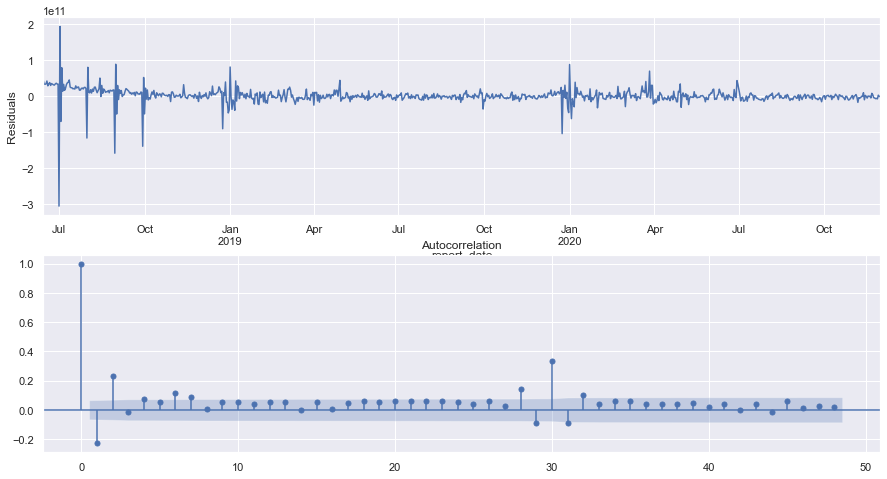

In [116]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки стационарны (подтверждается ADF-тестом), "немного" автокоррелированы (подтверждается коррелограммой)

In [114]:
pred = sarimax1.predict(tr_end, te_end, exog = exog_test)[1:]

In [116]:
print("Итоговый MAE = {} млрд. рублей".format(mean_absolute_error(pred, tes)/1e9))

Итоговый MAE = 15.178904192168545 млрд. рублей


In [11]:
pred = sarimax.predict(tr_end, te_end, exog = exog_test)[1:]

In [21]:
pred

2020-12-01    2.607501e+11
2020-12-02    2.671966e+11
2020-12-03    2.700459e+11
2020-12-04    2.765517e+11
2020-12-05    2.747698e+11
                  ...     
2021-03-31    2.417291e+11
2021-04-01    2.560726e+11
2021-04-02    2.588274e+11
2021-04-03    2.621052e+11
2021-04-04    2.630563e+11
Freq: D, Name: predicted_mean, Length: 125, dtype: float64

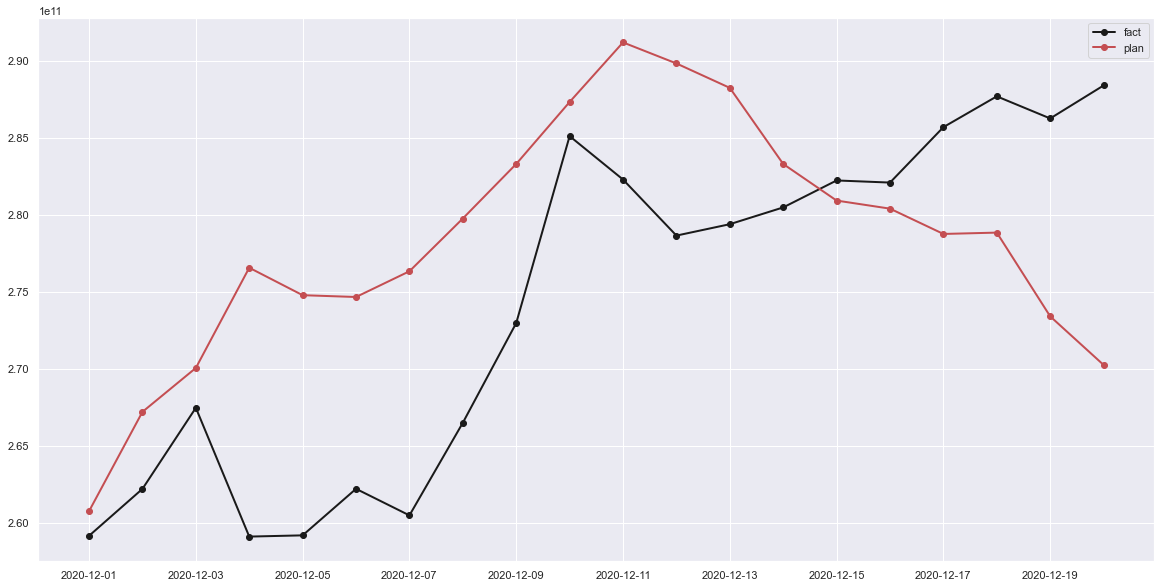

In [139]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(df_y_test, '-ok', linewidth = 2, label = 'fact')
ax.plot(pred, '-or',  linewidth = 2, label = 'plan')
ax.legend()
ax.grid(True)

In [16]:
print("Итоговы MAE = {} млрд. рублей".format(mean_absolute_error(pred, tes)/1e9))

Итоговы MAE = 15.48559343396159 млрд. рублей
